# Machine Learning to predict crop yield

##### The challenge is to understand and classify crop yield based on two set of environmental features; heat and drought. We have modelled both separately.

In [1]:
import pandas as pd

performance_data = pd.read_csv('performance_data.csv')
submission_template = pd.read_csv('submission_template.csv')
weather_data = pd.read_csv('weather_data.csv')

## Transforming weather data into useful metrics

Environmental data will be grouped by ENV_ID. Both averages and standard deviations will be obtained so as to capture the differences in weather. NB: Same average temperatures can hide different extreme environments. 

In [2]:
#Group data by crop id
weather_data_grouped_mean = weather_data.groupby(by='ENV_ID').mean()
weather_data_grouped_std = weather_data.groupby(by='ENV_ID').std()
weather_data_grouped_mean.head()
weather_data_grouped_std.head()
weather_data_grouped = weather_data_grouped_mean.join(weather_data_grouped_std,
                                                      lsuffix='_AVG',
                                                     rsuffix='_STD')
weather_data_grouped = weather_data_grouped.drop('DAY_NUM_AVG',axis=1)
weather_data_grouped.head()

,DAYL_AVG,PREC_AVG,SRAD_AVG,SWE_AVG,TMAX_AVG,TMIN_AVG,VP_AVG,DAY_NUM_STD,DAYL_STD,PREC_STD,SRAD_STD,SWE_STD,TMAX_STD,TMIN_STD,VP_STD
ENV_ID,,,,,,,,,,,,,,,
Env_1,43200.000043,1.684932,276.111781,11.167123,8.093151,-3.256164,630.356164,105.510663,10075.200862,4.544882,131.085275,16.046875,14.926959,13.574307,535.634711
Env_10,43200.946768,3.079452,294.978630,19.868493,12.095890,2.241096,874.191781,105.510663,8183.382184,5.974924,134.977729,31.810984,11.625704,9.839269,559.526111
Env_100,43200.000070,2.901370,296.714521,20.679452,12.616438,0.632877,820.054795,105.510663,8795.413435,7.152662,119.593751,30.413609,12.877466,12.410814,614.102577
Env_1000,43200.946854,2.000000,352.368219,0.997260,18.323288,2.883562,824.876712,105.510663,6955.702533,6.970897,111.010912,2.447805,11.374718,10.219944,674.104452
Env_1001,43200.946854,2.561644,341.681097,2.443836,17.701370,2.924658,862.246575,105.510663,6955.702533,8.697269,112.386846,5.729262,11.039508,10.119774,629.404388


## Joining performance and weather data

In [3]:
joined_df = performance_data.join(weather_data_grouped,on='ENV_ID')
joined_df.head()
joined_df.columns

heat_stress_df = joined_df[['HYBRID_ID','ENV_ID','TMAX_AVG','TMAX_STD',
                            'TMIN_AVG','TMIN_STD','DAYL_AVG','DAYL_STD',
                           'SRAD_AVG','SRAD_STD','YIELD']]
drought_stress_df = joined_df[['HYBRID_ID','ENV_ID','IRRIGATION','PREC_AVG','PREC_STD','KSAT',
                              'SWE_AVG','SWE_STD','VP_AVG','VP_STD','AWC','YIELD']]

# HEAT STRESS

In [4]:
#Setting non-numeric variables to index
heat_stress_df = heat_stress_df.set_index(['HYBRID_ID','ENV_ID'])
heat_stress_df.head()

TMAX_AVG   TMAX_STD  TMIN_AVG   TMIN_STD      DAYL_AVG  \
HYBRID_ID ENV_ID                                                           
H2782     Env_1   8.093151  14.926959 -3.256164  13.574307  43200.000043   
          Env_2   8.178082  14.860702 -3.290411  13.446089  43200.000054   
H2240     Env_3   9.805479  14.311170 -1.224658  12.901740  43200.000054   
H1527     Env_3   9.805479  14.311170 -1.224658  12.901740  43200.000054   
H1369     Env_3   9.805479  14.311170 -1.224658  12.901740  43200.000054   

                      DAYL_STD    SRAD_AVG    SRAD_STD     YIELD  
HYBRID_ID ENV_ID                                                  
H2782     Env_1   10075.200862  276.111781  131.085275  107.9577  
          Env_2   10001.326165  278.706849  130.288514   85.7498  
H2240     Env_3   10001.326165  274.112876  122.067104   74.6116  
H1527     Env_3   10001.326165  274.112876  122.067104   83.8191  
H1369     Env_3   10001.326165  274.112876  122.067104   81.7917

In [5]:
print('Total performance observations: ' + str(len(heat_stress_df)))
print('Total unique hybrids: ' + str(len(heat_stress_df.reset_index()['HYBRID_ID'].unique())))

Total performance observations: 387427
Total unique hybrids: 2452


## Setting up a Random Forest model

In [6]:
# Splitting data into training (70%), testing (20%) and validation (10%)
import sklearn
from sklearn.model_selection import train_test_split

train, test = train_test_split(heat_stress_df, test_size = 0.1, random_state=1)
x_train = train.iloc[:,0:-1]
y_train = train['YIELD']
x_test = test.iloc[:,0:-1]
y_test = test['YIELD']

In [7]:
# Setting up model
import numpy as np
from sklearn import linear_model
from sklearn import tree

tree_model_hs = tree.DecisionTreeRegressor()

# Fitting models
tree_model_hs.fit(x_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

## Model score

In [8]:
#Get score on the testing data
print('Model score equals: %.3f' % tree_model_hs.score(x_test,y_test))

Model score equals: 0.619


## Understanding the underlying parameters 

A key parameter in the Decision Tree Regressor is the minimum number of instances, i.e. the minimum number of samples required to be at a leaf node. We would expect the model to reduce its MSE to the training data when we decrease the minimum samples required to be a leaf node because more nodes would be added and the data would be more "fit" to the training data. However, with such procedure we would be exposed to an overfitting risk of the model to the training data and hence our MSE to the testing data would increase. 

Surprisingly, the figure below shows this does not apply in our case. The lower the number of instances required in a leaf node, the better for both the training and testing data. We can conclude that having a "super-tree" with as much leafes as number of instances is the best approach for both the training and testing data.

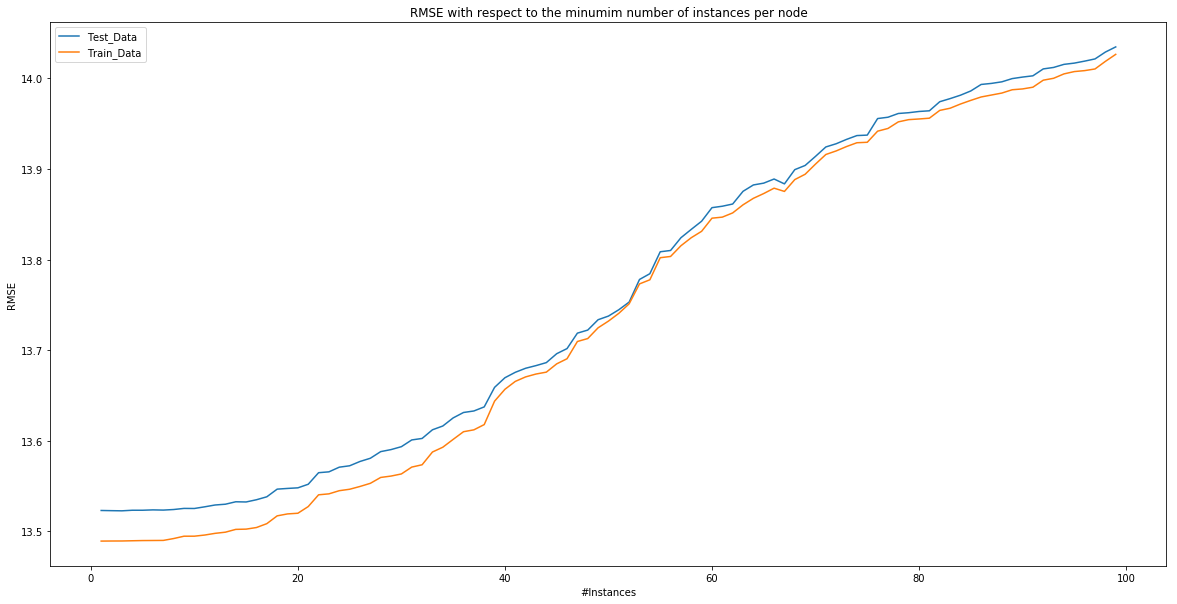

In [23]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(18,9))
ax0 = fig.add_subplot(111) 
RMSE_train = []
RMSE_test = []
iterations = 100

for i in range(1,iterations):
    #Parametrize the model and let i be the number of minimum instances per leaf node
    regression_model = tree.DecisionTreeRegressor(criterion="mse",min_samples_leaf=i)   
    #Train the model
    regression_model.fit(x_train,y_train)
    #Predict query instances
    predicted_train = regression_model.predict(x_train)
    predicted_test = regression_model.predict(x_test)
    #Calculate and append the RMSEs
    RMSE_train.append(np.sqrt(np.sum(((y_train-predicted_train)**2)/len(y_train))))
    RMSE_test.append(np.sqrt(np.sum(((y_test-predicted_test)**2)/len(y_test))))
    
ax0.plot(range(1,iterations),RMSE_test,label='Test_Data')
ax0.plot(range(1,iterations),RMSE_train,label='Train_Data')
ax0.legend()
ax0.set_title('RMSE with respect to the minumim number of instances per node')
ax0.set_xlabel('#Instances')
ax0.set_ylabel('RMSE')
plt.show()

The same perspective but with model scores (ranging from 0

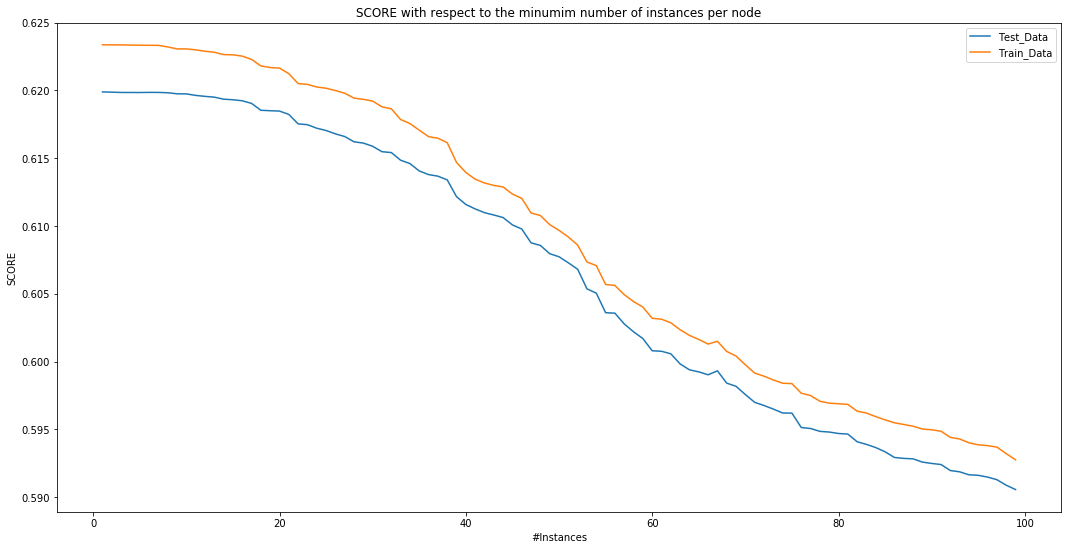

In [24]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(18,9))
ax0 = fig.add_subplot(111) 
SCORE_train = []
SCORE_test = []
iterations = 100

for i in range(1,iterations):
    #Parametrize the model and let i be the number of minimum instances per leaf node
    regression_model = tree.DecisionTreeRegressor(criterion="mse",min_samples_leaf=i)   
    #Train the model
    regression_model.fit(x_train,y_train)
    #Get scores
    SCORE_train.append(regression_model.score(x_train,y_train))
    SCORE_test.append(regression_model.score(x_test,y_test))
        
ax0.plot(range(1,iterations),SCORE_test,label='Test_Data')
ax0.plot(range(1,iterations),SCORE_train,label='Train_Data')
ax0.legend()
ax0.set_title('SCORE with respect to the minumim number of instances per node')
ax0.set_xlabel('#Instances')
ax0.set_ylabel('SCORE')
plt.show()

## Decision Tree illustration

DAYL_STD is the most decisive factor when it comes to predicting yield

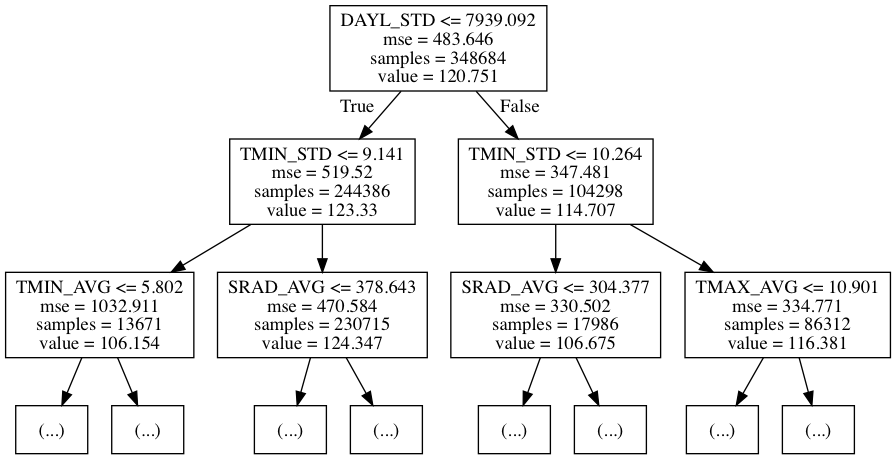

In [9]:
import pydotplus 
from IPython.display import Image

feature_names = [key for key in heat_stress_df.columns if not key == 'YIELD']

dot_data = tree.export_graphviz(tree_model_hs,
                                max_depth=2,
                                out_file=None,
                                feature_names=feature_names)

graph = pydotplus.graphviz.graph_from_dot_data(dot_data)

Image(graph.create_png())

# DROUGHT STRESS

In [10]:
#Setting non-numeric variables to index
drought_stress_df = drought_stress_df.set_index(['HYBRID_ID','ENV_ID'])
drought_stress_df.head()

IRRIGATION  PREC_AVG  PREC_STD  KSAT    SWE_AVG    SWE_STD  \
HYBRID_ID ENV_ID                                                              
H2782     Env_1         DRY  1.684932  4.544882   9.4  11.167123  16.046875   
          Env_2         DRY  1.621918  4.372688  10.2   9.545205  13.847730   
H2240     Env_3        NONE  1.183562  4.047351   9.9   4.394521   7.829079   
H1527     Env_3        NONE  1.183562  4.047351   9.9   4.394521   7.829079   
H1369     Env_3        NONE  1.183562  4.047351   9.9   4.394521   7.829079   

                      VP_AVG      VP_STD    AWC     YIELD  
HYBRID_ID ENV_ID                                           
H2782     Env_1   630.356164  535.634711  18.65  107.9577  
          Env_2   612.602740  528.588280  18.75   85.7498  
H2240     Env_3   717.917808  585.217198  18.95   74.6116  
H1527     Env_3   717.917808  585.217198  18.95   83.8191  
H1369     Env_3   717.917808  585.217198  18.95   81.7917

### Cleaning data

In [11]:
# Converting irrigation to numeric values
def irrigation_converter(string):
    import numpy as np
    if string == np.nan:
        return np.nan
    if string == 'NONE' or string == 'DRY':
        return 0
    if string == 'ECO':
        return 1
    if string == 'LIRR':
        return 2
    if string == 'IRR':
        return 3
    else:
        next

drought_stress_df['IRRIGATION'] = drought_stress_df['IRRIGATION'].apply(irrigation_converter)
print('Total performance observations: ' + str(len(drought_stress_df)))
print('Total unique hybrids: ' + str(len(drought_stress_df.reset_index()['HYBRID_ID'].unique())))

Total performance observations: 387427
Total unique hybrids: 2452


In [12]:
# Drop nan
drought_stress_df.dropna(inplace=True)

print('Total performance observations: ' + str(len(drought_stress_df)))
print('Total unique hybrids: ' + str(len(drought_stress_df.reset_index()['HYBRID_ID'].unique())))

Total performance observations: 379143
Total unique hybrids: 2452


## Setting up a Random Forest model

In [13]:
# Splitting data
import sklearn
from sklearn.model_selection import train_test_split

train, test = train_test_split(drought_stress_df, test_size = 0.3, random_state=1)
x_train = train.iloc[:,0:-1]
y_train = train['YIELD']
x_test = test.iloc[:,0:-1]
y_test = test['YIELD']

In [14]:
# Setting up model
import numpy as np
from sklearn import linear_model
from sklearn import tree

tree_model_ds = tree.DecisionTreeRegressor()

# Fitting models
tree_model_ds.fit(x_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

## Model score

In [15]:
#Get score on the testing data
print(tree_model_ds.score(x_test,y_test))

0.6198724918821297


## Decision Tree illustration

IRRIGATION is the most decisive factor when it comes to predicting yield

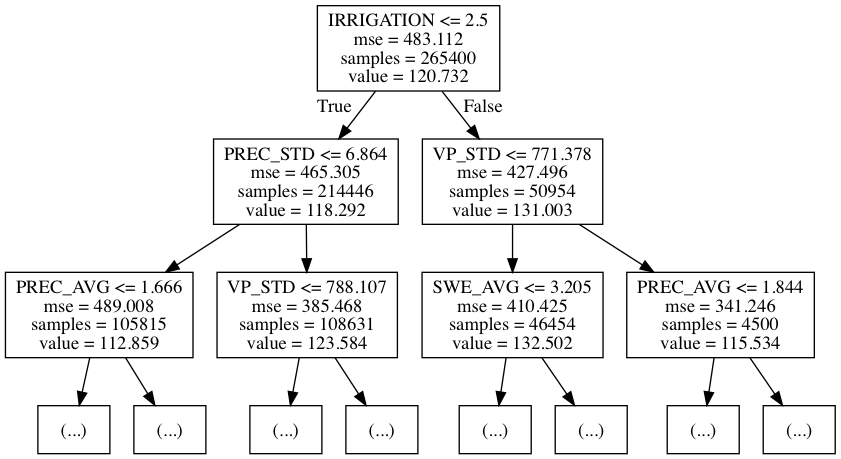

In [16]:
import pydotplus 
from IPython.display import Image

feature_names = [key for key in drought_stress_df.columns if not key == 'YIELD']

dot_data = tree.export_graphviz(tree_model_ds,
                                max_depth=2,
                                out_file=None,
                                feature_names=feature_names)

graph = pydotplus.graphviz.graph_from_dot_data(dot_data)

Image(graph.create_png())

## Find feature importance